# Tracking Depression and Suicidal Ideation in Social Media
### Analysis and Dashboarding for tracking features associated with mental health risk
## Part 2 - Text Classification; Mental health posts vs. Medical/Social posts

### Table of Contents

* <a href='#Part_1'> Abstract</a> 
* <a href='#Part_2'> Obtain & Scrub</a>   
* <a href='#Part_3'> Model Training/Testing</a> 
* <a href='#Part_4'> Hyperparameter Optimization</a>
* <a href='#Part_5'> Final Model</a>
* <a href='#Part_6'> Conclusions</a>

In [341]:
#Importing Libraries
import requests
import nltk
import json
import time
import pandas as pd
import numpy as np
import re
import praw
import prawcore
import datetime as dt
import matplotlib.pyplot as plt
import scipy
import pymongo
import functions as functions
import os
import patsy as py
import seaborn as sns
import itertools
import xgboost as xgb
import tensorflow
import sklearn
import keras_metrics
import shap
import pickle

from importlib import reload
from numpy import mean, var
from math import sqrt
from os import path
from pymongo import MongoClient, errors
from pymongo.errors import InvalidDocument
from patsy import dmatrices
from textblob import TextBlob

from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.corpus.reader.wordnet import ADJ, ADJ_SAT, ADV, NOUN
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from sklearn import preprocessing, svm, tree, model_selection
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import precision_score, recall_score, accuracy_score,precision_recall_fscore_support, auc
from sklearn.metrics import f1_score, confusion_matrix, make_scorer, classification_report, roc_auc_score, SCORERS
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier                          
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer


from xgboost import XGBClassifier, plot_importance
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from gensim.models import Word2Vec
from treeinterpreter import treeinterpreter as ti
from shap import TreeExplainer

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing import text, sequence
from keras.preprocessing.sequence import pad_sequences
from keras_metrics import f1_score
from keras.models import Model, Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D, Input, Dense, LSTM, GRU, Embedding


from functions import connect_to_reddit, connect_to_mongo, get_stem_abs, get_stop_words, text_cleaner, get_date;
from functions import submissions_to_mongo, clean_df, get_tot_word, get_abs_word_count, get_perc_abs, cohend;
from functions import get_abs_chart, get_post_distribution, wordcloud, clean_text, get_distribution, get_word_freq;
from functions import evaluate, plot_confusion_matrix, get_authors, get_author_posts, check_exists, mongo_to_df;


os.environ['KMP_DUPLICATE_LIB_OK']='True'
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [319]:
#connecting to mongo database
client = connect_to_mongo()
# connecting to reddit api
reddit = connect_to_reddit()

now connected to mongo
pillosoft connecting to reddit API


<a id='Part_1'></a>

# Abstract

Mental-Health clinicians face many obstacles, among them include the ability to diagnose patients with serious mental illness when typically they are only allotted one hour sessions periodically in which to collect as much information as possible to create a diagnosis. At the moment, the best supplement that clinicians have include interviewing family and friends to gather more information, which most patients object to due to privacy concerns.

Having access to additional data would indeed be beneficial to mental health clinicians to assist in accurately identifying patients who qualify as depressed, or suicidal. Therefore, I will attempt to build a classifier that combs through a patient's social media posts and can somewhat accurately identify whether or not the patient is likely to be depressed, anxious, and/or suicidal or not.

In this section, we will take all the posts from all over reddit from those who have posted in the suicide/depression/anxiety forum at one point, and build a classifier that can identify their posts versus authors who have posted in chronic illness and/or hobby type forums. Taking all of these authors' posts from all over reddit helps to generalize the data a bit more, so we can use the language of a poster who isn't just necessarily talking about mental health issues in a mental-health specific reddit forum, but we can also look at their language across all other forums that they have posted in to see if we can identify any overall patterns in text.

In [321]:

abs_word_list = ['absolutely', 'all', 'always', 'complete', 'completely', 'constant', 'constantly', 'definitely', 
                 'entire', 'ever', 'every', 'everyone', 'everything', 'full', 'must', 'never', 'nothing', 
                 'totally', 'whole']

remove_words = ["http", "https", "www", "com", "reddit", "jpg", 'x', 'b', 'f', 'r', 'c', 'd', 'e', 'f', 
               'g', 'h', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'op', 'q', 's', 't', 'u', 'v', 'w', 'y', 'z',
               '00', '01', '04', '10', '100', '1000', '1000mg', '100mg', '100x', '108', '10k', '10lbs', 
                '10pm', '10th', '10yo', '10yrs', '11', '119', '11am', '11d', '11th', '12', '120', '12g', 
                '12ga', '12ish', '13', '14', '140', '146', '15', '150', '150mg', '1549449839413', '15min', 
                '16', '160', '162', '16f', '16y', '17', '170', '17f', '17th', '17yo', '18', '180', '189', 
                '18months', '18th', '19', '1950', '1974', '1996', '19o', '19th', '1drl', '1k', '1mg', '1st', 
                '1x', '20', '200', '2000', '2003', '2007', '200mg', '2010', '2012', '2014', '2015', '2016', 
                '2017', '2018', '2019', '20mg', '20oz', '20th', '21', '215lbs', '22', '22m', '23', '2300', 
                '23andme', '24', '24hrs', '25', '250', '2500', '250mg', '258', '25mg', '25th', '26', '260lbs', 
                '26yo', '27', '270', '27th', '27year', '28', '28th', '29', '2ahukewiuracn9kbgahvb6kqkhy2ld', 
                '2am', '2l', '2lbs', '2mo', '2nd', '2wks', '2x', '2years', '2yrs', '30', '300', '3000', 
                '3000mg', '300mg', '304', '30th', '31', '310', '31st', '32', '325mg', '32oz', '33', '34', 
                '340', '35', '350', '357', '37', '38', '39', '3am', '3lb', '3mg', '3pm', '3rd', '3rds', '40', 
                '400', '40cl', '40km', '40lbs', '40mg', '40s', '40th', '42', '43m', '44', '45', '450', '48', 
                '48oz', '49', '4am', '4th', '50', '500', '500mg', '50mcg', '50mg', '50oz', '50s', '5150', '5600',
                '5677676', '57', '5k', '5mg', '5pm', '5th', '60', '600', '600mg', '60k', '61', '63', '64', '6am',
                '6mg', '6th', '6yrs', '70', '700', '70cl', '70s', '72', '75mg', '79558b7f', '7pm', '7t4ngdpbitq',
                '7th', '80', '800', '8th', '90', '92', '95', '99', '9am', '9th', '___', '_a', '_anyone', '_be',
                '_food', '_for', '_in', '_interested', '_me', '_tracker', 'aa', 'aans', 'like']

pre_stop_words = list(stopwords.words("english"))

moderators = ['S2S2S2S2S2','Psy-Kosh','SicSemperHumanus','SQLwitch','UnDire','pkbooo','skyqween','MykeeB',
              'circinia','svneko','MuffinMedic','remyschnitzel','vodkalimes','dwade333miami','anxietymods',
              'BotBust','MrZalarox','Pi25','analemmaro', 'abhava-sunya','sofar1776','AccioInternets','palisade2621',
              'Hermiones_Teaspoon','AweBeyCon','dancingonfire','midnightdragon','elbowsss','Chefjones','pezes',
              'sulkee','Greypo','exoendo','Jakeable','MeghanAM','JoyousCacophony','hansjens47','Qu1nlan',
              'english06','samplebitch','optimalg','rhiever','Geographist','frostickle','NonNonHeinous',
              'Vizual-Statistix','sarahbotts','zonination','spermface','yelper','mungoflago','ostedog','rsrsrsrs',
              'townie_immigrant','JoeAllan','theReluctantHipster','AutoModerator', 'iimsorryy','wanderlusterer',
              'awaxa','dosman711','mmccullen','Ariensus','turtletechnology','cascer1','cluckj','adidushi',
              'Muffinzz','IHaveTheBestCandy','crilen','Cerenkov_Blue', 'binarysneaker','vomita_conejitos','polezo']

subreddit_list = ['suicidewatch', 'depression', 'anxiety',
                  'diabetes', 'heartdisease', 'gout', 'copd',
                  'travel', 'basketball', 'harrypotter']

stem_abs = get_stem_abs(abs_word_list)

stop_words = get_stop_words(remove_words, abs_word_list, pre_stop_words)

stop words list length is now:
179
adding words from include list
new words have been added, stop words list length is now:
429
removing exlude words
exclude list words removed. stop words length is now:
428


<a id='Part_2'></a>

# Obtain & Scrub

In [320]:
# accessing collections
reddit_db = client["reddit"]
reddit_submissions = reddit_db['submissions_for_author_analysis']
suicide_redditors = reddit_db['suicide']
dep_redditors = reddit_db['dep']
anx_redditors = reddit_db['anx']
gout_redditors = reddit_db['gout']
db_redditors = reddit_db['db']
copd_redditors = reddit_db['copd']
htn_redditors = reddit_db['htn']
trav_redditors = reddit_db['travel']
bb_redditors = reddit_db['bb']
hp_redditors = reddit_db['hp']

In [432]:
# Creating a dataframe from our mongo database collection
reddit_df = None
reddit_df = mongo_to_df(reddit_df, reddit_submissions)

In [436]:
# Creating separate lists of all of the authors who have posted in each forum
suicide, anx, dep, gout, htn, copd, db, travel, bb, hp = ([],)*10
forum_list = [suicide, anx, dep, gout, htn, copd, db, travel, bb, hp]
for forum in forum_list:
    get_authors(list_name=forum, df=reddit_df) # appending all authors in each forum to their respective list

# Creating a dictionary to map author lists to the data base we will be dumping 
# all of their reddit posts from all over reddit into
author_list_to_db_dict = {suicide:suicide_redditors, anx:anx_redditors, dep:dep_redditors, gout:gout_redditors, 
                          htn:htn_redditors, copd:copd_redditors, db:db_redditors, travel:trav_redditors, 
                          bb:bb_redditors, hp:hp_redditors}
# Finding posts by author name all over reddit and storing them in their respective named databases
for key,value in author_list_to_db_dict:
    get_author_posts(author_list=key, stop_words=stop_words, stem_abs=stem_abs, db_collection=value)

In [335]:
# converting mongo db collections to dataframes
suicide_df, anx_df, dep_df, gout_df, htn_df, copd_df, db_df, travel_df, bb_df, hp_df = (None,)*10
suicide_df = mongo_to_df(suicide_df, suicide_redditors)
anx_df = mongo_to_df(anx_df, anx_redditors)
dep_df = mongo_to_df(dep_df, dep_redditors)
gout_df = mongo_to_df(gout_df, gout_redditors)
htn_df = mongo_to_df(htn_df, htn_redditors)
copd_df = mongo_to_df(copd_df, copd_redditors)
db_df = mongo_to_df(db_df, db_redditors)
travel_df = mongo_to_df(travel_df, trav_redditors)
bb_df = mongo_to_df(bb_df, bb_redditors)
hp_df = mongo_to_df(hp_df, hp_redditors)

In [408]:
# concatenating the dataframes that includes chronic illness forum posters 
# and hobby forum posters posts from all over reddit
# theory=these authors are not depressed/suicidal, so their posts in other subreddits will have distinct language

df = pd.concat([travel_df, bb_df, copd_df, db_df])
df.drop_duplicates(subset='cleaned_text', inplace=True)
# removing rows that contain forum posts in the suicide/depression subreddits
df = df[df.subreddit != 'SuicideWatch']
df = df[df.subreddit != 'depression']


# creating a dataframe that includes depression and suicidal ideation 
# forum posters and their posts from all over reddit
# theory= these authors are depressed/suicidal, so their posts in other subreddits will have distinct language
mh_df = pd.concat([suicide_df, dep_df, anx_df])
mh_df.drop_duplicates(subset='cleaned_text', inplace=True)

# creating labels
df['labels'] = 0
mh_df['labels'] = 1

# joining the dataframes 
final_df = pd.concat([mh_df, df])
final_df.drop_duplicates(subset='cleaned_text', inplace=True)

<a id='Part_3'></a>

# Model Training/Testing

In [409]:
# train test split:
X_train, X_test, y_train, y_test = train_test_split(final_df.cleaned_text, final_df.labels, 
                                                    train_size=0.65, test_size=0.35)

### 1. Logistic Regression Classifier:

In [410]:
# Utilizing pipelines to count vectorize, TF-IFF transform, and run the classifier:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', LogisticRegression()),])
text_clf.fit(X_train, y_train)
predicted_test = text_clf.predict(X_test)
predicted_train = text_clf.predict(X_train)
print("Logistic Regression Results")
print("")
evaluate(y_train, predicted_train, y_test, predicted_test, class_names=class_names)

### 2. Random Forest Classifier:

Random Forest Results

Training Precision:  0.9970736465615347
Testing Precision:  0.7505986999657885



Training Recall:  0.9773705179282869
Testing Recall:  0.6518122400475341



Training Accuracy:  0.9872071639881667
Testing Accuracy:  0.7177850356294537



Training F1 Score:  0.9871237727345888
Testing F1 Score:  0.6977261885832405



Confusion matrix, without normalization


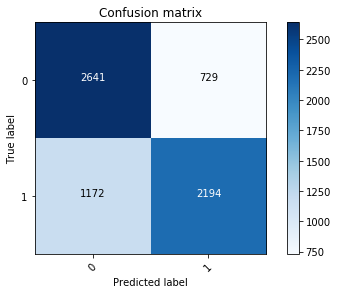




Normalized confusion matrix


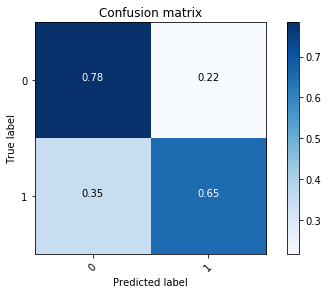

In [414]:
# Utilizing pipelines to Count Vectorize, TF-IDF transform, and run the classifier:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', RandomForestClassifier()),])
text_clf.fit(X_train, y_train)
predicted_test = text_clf.predict(X_test)
predicted_train = text_clf.predict(X_train)
print("Random Forest Results")
print("")
evaluate(y_train, predicted_train, y_test, predicted_test, class_names=class_names)

### 3. Adaboost Classifier:

Adaboost Results

Training Precision:  0.7578966259870783
Testing Precision:  0.7358370464672184



Training Recall:  0.672988047808765
Testing Recall:  0.6868686868686869



Training Accuracy:  0.7280722795234669
Testing Accuracy:  0.7203087885985748



Training F1 Score:  0.7129231028952477
Testing F1 Score:  0.7105101413644745



Confusion matrix, without normalization


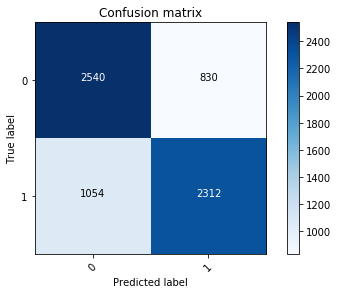




Normalized confusion matrix


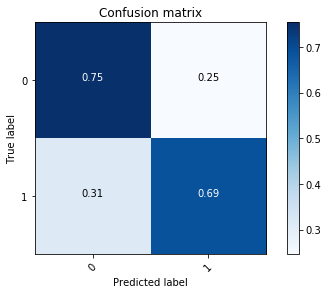

In [415]:
# Utilizing pipelines to Count Vectorize, TF-IDF transform, and run the classifier:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', AdaBoostClassifier()),])
text_clf.fit(X_train, y_train)
predicted_test = text_clf.predict(X_test)
predicted_train = text_clf.predict(X_train)
print("Adaboost Results")
print("")
evaluate(y_train, predicted_train, y_test, predicted_test, class_names=class_names)

### 4. Gradient Boosting Classifier

Gradient Boosting Results

Training Precision:  0.8415799532809514
Testing Precision:  0.8021228203184231



Training Recall:  0.6315537848605578
Testing Recall:  0.6286393345216874



Training Accuracy:  0.7554969217238346
Testing Accuracy:  0.7369358669833729



Training F1 Score:  0.7215950473415879
Testing F1 Score:  0.704863424383744



Confusion matrix, without normalization


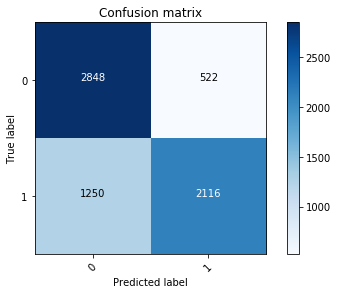




Normalized confusion matrix


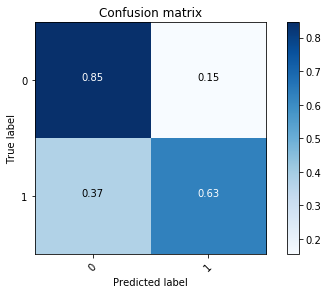

In [416]:
# Utilizing pipelines to Count Vectorize, TF-IDF transform, and run the classifier:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', GradientBoostingClassifier()),])
text_clf.fit(X_train, y_train)
predicted_test = text_clf.predict(X_test)
predicted_train = text_clf.predict(X_train)
print("Gradient Boosting Results")
print("")
evaluate(y_train, predicted_train, y_test, predicted_test, class_names=class_names)

### 5. XGBoost Classifier

XGBoost Results

Training Precision:  0.8402534965034965
Testing Precision:  0.8061104582843713



Training Recall:  0.6127490039840637
Testing Recall:  0.6114081996434938



Training Accuracy:  0.7472615335412169
Testing Accuracy:  0.732333729216152



Training F1 Score:  0.7086904432771173
Testing F1 Score:  0.6953877344145971



Confusion matrix, without normalization


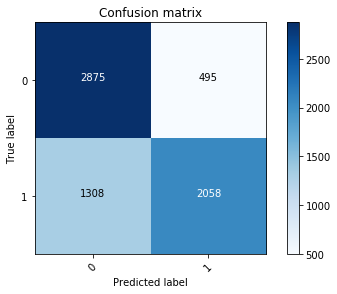




Normalized confusion matrix


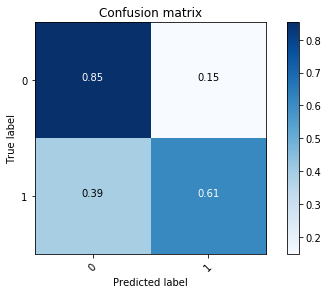

In [417]:
# Utilizing pipelines to Count Vectorize, TF-IDF transform, and run the classifier:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', XGBClassifier()),])
text_clf.fit(X_train, y_train)
predicted_test = text_clf.predict(X_test)
predicted_train = text_clf.predict(X_train)
print("XGBoost Results")
print("")
evaluate(y_train, predicted_train, y_test, predicted_test, class_names=class_names)

### 6. SGD Classifier:

Stochastic Gradient Descent Results

Training Precision:  0.9178987650026091
Testing Precision:  0.8027350427350427



Training Recall:  0.8409561752988047
Testing Recall:  0.6975638740344623



Training Accuracy:  0.8824658191412809
Testing Accuracy:  0.7632125890736342



Training F1 Score:  0.8777445109780438
Testing F1 Score:  0.7464632013988237



Confusion matrix, without normalization


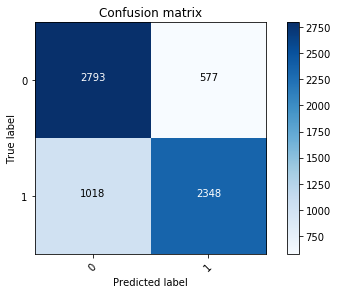




Normalized confusion matrix


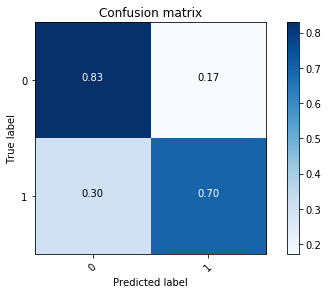

In [418]:
# Utilizing pipelines to Count Vectorize, TF-IDF transform, and run the classifier:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier()),])
text_clf.fit(X_train, y_train)
predicted_test = text_clf.predict(X_test)
predicted_train = text_clf.predict(X_train)
print("Stochastic Gradient Descent Results")
print("")
evaluate(y_train, predicted_train, y_test, predicted_test, class_names=class_names)

### 7. Multinomial Naive Bayes Classifier:

Multinomial Naive Bayes Results

Training Precision:  0.8086166471277842
Testing Precision:  0.7357977711334602



Training Recall:  0.8793625498007969
Testing Recall:  0.8042186571598336



Training Accuracy:  0.8350523706724234
Testing Accuracy:  0.7578681710213777



Training F1 Score:  0.8425070616077563
Testing F1 Score:  0.7684882895670688



Confusion matrix, without normalization


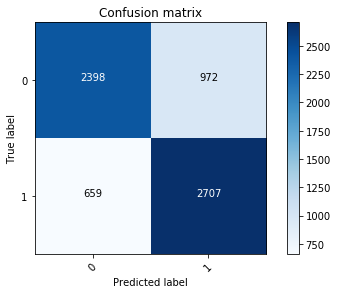




Normalized confusion matrix


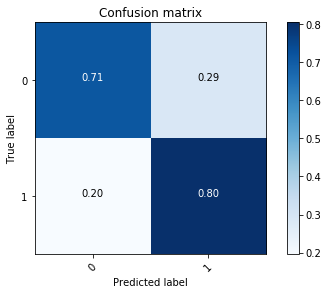

In [419]:
# Utilizing pipelines to Count Vectorize, TF-IDF transform, and run the classifier:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),])
text_clf.fit(X_train, y_train)
predicted_test = text_clf.predict(X_test)
predicted_train = text_clf.predict(X_train)
print("Multinomial Naive Bayes Results")
print("")
evaluate(y_train, predicted_train, y_test, predicted_test, class_names=class_names)

Looks like our Multinomial Naive Bayes was one of the better performers with a pretty high recall of 80% and a high F1 score of 76% with an overall accuracy of 75% on our test data. Let's see if we can tune some of the parameters to improve our model further...

<a id='Part_4'></a>

# Hyperparameter Tuning

In [422]:
#pipeline to pass to gridsearch
pipe = Pipeline([('cv', CountVectorizer()), ('tf', TfidfTransformer()), ('mnb', MultinomialNB())])
#parameters to pass to gridsearch
grid_params = {'cv__ngram_range': [(1,1), (1,2), (1,3)],
               'cv__max_df': np.linspace(0.1, 1, 10),
               'cv__binary': [True, False],
               'tf__norm': [None, 'l1', 'l2'],
               'mnb__alpha': np.linspace(0.5, 1.5, 3),
               'mnb__fit_prior': [True, False]}

In [423]:
# Utilizing GridSearchCV to scan all parameters and evaluate classifier performance with each parameter passed
gs = GridSearchCV(estimator=pipe, param_grid=grid_params, scoring='balanced_accuracy', cv=3, verbose=0, return_train_score = True)
gs.fit(X_train, y_train)
print("Best Score: ", gs.best_score_)
print("Best Params: ", gs.best_params_)


Fitting 3 folds for each of 1080 candidates, totalling 3240 fits
[CV] cv__binary=True, cv__max_df=0.1, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  cv__binary=True, cv__max_df=0.1, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=None, total=   0.8s
[CV] cv__binary=True, cv__max_df=0.1, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=None 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV]  cv__binary=True, cv__max_df=0.1, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=None, total=   0.7s
[CV] cv__binary=True, cv__max_df=0.1, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=True, cv__max_df=0.1, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=None, total=   0.8s
[CV] cv__binary=True, cv__max_df=0.1, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l1 
[CV]  cv__binary=True, cv__max_df=0.1, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l1, total=   0.9s
[CV] cv__binary=True, cv__max_df=0.1, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l1 
[CV]  cv__binary=True, cv__max_df=0.1, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l1, total=   0.7s
[CV] cv__binary=True, cv__max_df=0.1, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l1 
[CV]  cv__binary=True, cv__max_df=0.1,

[CV]  cv__binary=True, cv__max_df=0.1, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l2, total=   0.8s
[CV] cv__binary=True, cv__max_df=0.1, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=True, cv__max_df=0.1, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=None, total=   0.8s
[CV] cv__binary=True, cv__max_df=0.1, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=True, cv__max_df=0.1, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=None, total=   0.7s
[CV] cv__binary=True, cv__max_df=0.1, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=True, cv__max_df=0.1, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=None, total=   0.8s
[CV] cv__binary=True, cv__max_df=0.1, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l1 
[CV]  cv__binary=True, cv__max_

[CV]  cv__binary=True, cv__max_df=0.1, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l2, total=   2.5s
[CV] cv__binary=True, cv__max_df=0.1, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l2 
[CV]  cv__binary=True, cv__max_df=0.1, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l2, total=   2.5s
[CV] cv__binary=True, cv__max_df=0.1, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l2 
[CV]  cv__binary=True, cv__max_df=0.1, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l2, total=   2.5s
[CV] cv__binary=True, cv__max_df=0.1, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=True, cv__max_df=0.1, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=None, total=   2.5s
[CV] cv__binary=True, cv__max_df=0.1, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=True, cv__max_df

[CV]  cv__binary=True, cv__max_df=0.1, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l1, total=   2.5s
[CV] cv__binary=True, cv__max_df=0.1, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l1 
[CV]  cv__binary=True, cv__max_df=0.1, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l1, total=   2.5s
[CV] cv__binary=True, cv__max_df=0.1, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l2 
[CV]  cv__binary=True, cv__max_df=0.1, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l2, total=   2.5s
[CV] cv__binary=True, cv__max_df=0.1, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l2 
[CV]  cv__binary=True, cv__max_df=0.1, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l2, total=   2.5s
[CV] cv__binary=True, cv__max_df=0.1, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l2 
[CV]  cv__binary=True, cv__max_df=0.

[CV]  cv__binary=True, cv__max_df=0.1, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=None, total=   5.5s
[CV] cv__binary=True, cv__max_df=0.1, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l1 
[CV]  cv__binary=True, cv__max_df=0.1, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l1, total=   5.6s
[CV] cv__binary=True, cv__max_df=0.1, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l1 
[CV]  cv__binary=True, cv__max_df=0.1, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l1, total=   5.7s
[CV] cv__binary=True, cv__max_df=0.1, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l1 
[CV]  cv__binary=True, cv__max_df=0.1, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l1, total=   5.7s
[CV] cv__binary=True, cv__max_df=0.1, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l2 
[CV]  cv__binary=True, cv__max_df=

[CV]  cv__binary=True, cv__max_df=0.2, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=None, total=   0.7s
[CV] cv__binary=True, cv__max_df=0.2, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=None 
[CV]  cv__binary=True, cv__max_df=0.2, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=None, total=   0.7s
[CV] cv__binary=True, cv__max_df=0.2, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=None 
[CV]  cv__binary=True, cv__max_df=0.2, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=None, total=   0.7s
[CV] cv__binary=True, cv__max_df=0.2, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l1 
[CV]  cv__binary=True, cv__max_df=0.2, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l1, total=   0.8s
[CV] cv__binary=True, cv__max_df=0.2, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l1 
[CV]  cv__binary=True, cv_

[CV]  cv__binary=True, cv__max_df=0.2, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l2, total=   0.7s
[CV] cv__binary=True, cv__max_df=0.2, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l2 
[CV]  cv__binary=True, cv__max_df=0.2, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l2, total=   0.8s
[CV] cv__binary=True, cv__max_df=0.2, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=None 
[CV]  cv__binary=True, cv__max_df=0.2, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=None, total=   0.8s
[CV] cv__binary=True, cv__max_df=0.2, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=None 
[CV]  cv__binary=True, cv__max_df=0.2, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=None, total=   0.7s
[CV] cv__binary=True, cv__max_df=0.2, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=None 
[CV]  cv__binary=True, cv__ma

[CV]  cv__binary=True, cv__max_df=0.2, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l1, total=   2.8s
[CV] cv__binary=True, cv__max_df=0.2, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l2 
[CV]  cv__binary=True, cv__max_df=0.2, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l2, total=   2.8s
[CV] cv__binary=True, cv__max_df=0.2, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l2 
[CV]  cv__binary=True, cv__max_df=0.2, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l2, total=   2.7s
[CV] cv__binary=True, cv__max_df=0.2, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l2 
[CV]  cv__binary=True, cv__max_df=0.2, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l2, total=   2.8s
[CV] cv__binary=True, cv__max_df=0.2, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=None 
[CV]  cv__binary=True, cv__max_df=0.2, cv

[CV]  cv__binary=True, cv__max_df=0.2, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l1, total=   6.5s
[CV] cv__binary=True, cv__max_df=0.2, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l1 
[CV]  cv__binary=True, cv__max_df=0.2, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l1, total=   6.3s
[CV] cv__binary=True, cv__max_df=0.2, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l1 
[CV]  cv__binary=True, cv__max_df=0.2, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l1, total=   7.0s
[CV] cv__binary=True, cv__max_df=0.2, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l2 
[CV]  cv__binary=True, cv__max_df=0.2, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l2, total=   8.0s
[CV] cv__binary=True, cv__max_df=0.2, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l2 
[CV]  cv__binary=True, cv__max_df=0.2, cv__n

[CV]  cv__binary=True, cv__max_df=0.2, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=None, total=   7.6s
[CV] cv__binary=True, cv__max_df=0.2, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=True, cv__max_df=0.2, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=None, total=   7.1s
[CV] cv__binary=True, cv__max_df=0.2, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l1 
[CV]  cv__binary=True, cv__max_df=0.2, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l1, total=   9.5s
[CV] cv__binary=True, cv__max_df=0.2, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l1 
[CV]  cv__binary=True, cv__max_df=0.2, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l1, total=   6.7s
[CV] cv__binary=True, cv__max_df=0.2, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l1 
[CV]  cv__binary=True, cv__max_df=0.2,

[CV]  cv__binary=True, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l2, total=   1.2s
[CV] cv__binary=True, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l2 
[CV]  cv__binary=True, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l2, total=   1.2s
[CV] cv__binary=True, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l2 
[CV]  cv__binary=True, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l2, total=   1.0s
[CV] cv__binary=True, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=True, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=None, total=   1.2s
[CV] cv__binary=True, cv__max_df=0.

[CV]  cv__binary=True, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=None, total=   1.0s
[CV] cv__binary=True, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=None 
[CV]  cv__binary=True, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=None, total=   1.0s
[CV] cv__binary=True, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l1 
[CV]  cv__binary=True, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l1, total=   1.2s
[CV] cv__binary=True, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l1 
[CV]  cv__binary=True, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l1, total=   1.1s
[CV] cv__binary=True, cv__max_d

[CV]  cv__binary=True, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l1, total=   3.8s
[CV] cv__binary=True, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l1 
[CV]  cv__binary=True, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l1, total=   4.3s
[CV] cv__binary=True, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l2 
[CV]  cv__binary=True, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l2, total=   3.1s
[CV] cv__binary=True, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l2 
[CV]  cv__binary=True, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l2, total=   4.0s
[CV] cv__binary=True, cv__max_df=0.300000000

[CV]  cv__binary=True, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l2, total=   3.0s
[CV] cv__binary=True, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l2 
[CV]  cv__binary=True, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l2, total=   2.9s
[CV] cv__binary=True, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=True, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=None, total=   6.1s
[CV] cv__binary=True, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=True, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=None, total=   5.9s
[CV] cv__binary=True, cv__max_df=

[CV]  cv__binary=True, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=None, total=   7.1s
[CV] cv__binary=True, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=None 
[CV]  cv__binary=True, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=None, total=   6.5s
[CV] cv__binary=True, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l1 
[CV]  cv__binary=True, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l1, total=   6.3s
[CV] cv__binary=True, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l1 
[CV]  cv__binary=True, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l1, total=   8.0s
[CV] cv__binary=True, cv__max_d

[CV]  cv__binary=True, cv__max_df=0.4, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l1, total=   0.7s
[CV] cv__binary=True, cv__max_df=0.4, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l2 
[CV]  cv__binary=True, cv__max_df=0.4, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l2, total=   0.9s
[CV] cv__binary=True, cv__max_df=0.4, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l2 
[CV]  cv__binary=True, cv__max_df=0.4, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l2, total=   1.0s
[CV] cv__binary=True, cv__max_df=0.4, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l2 
[CV]  cv__binary=True, cv__max_df=0.4, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l2, total=   1.4s
[CV] cv__binary=True, cv__max_df=0.4, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=None 
[CV]  cv__binary=True, cv__max_df=0.4, cv

[CV]  cv__binary=True, cv__max_df=0.4, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l1, total=   0.8s
[CV] cv__binary=True, cv__max_df=0.4, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l1 
[CV]  cv__binary=True, cv__max_df=0.4, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l1, total=   0.7s
[CV] cv__binary=True, cv__max_df=0.4, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l1 
[CV]  cv__binary=True, cv__max_df=0.4, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l1, total=   0.8s
[CV] cv__binary=True, cv__max_df=0.4, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l2 
[CV]  cv__binary=True, cv__max_df=0.4, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l2, total=   0.8s
[CV] cv__binary=True, cv__max_df=0.4, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l2 
[CV]  cv__binary=True, cv__max_df=0.4, cv__n

[CV]  cv__binary=True, cv__max_df=0.4, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=None, total=   3.4s
[CV] cv__binary=True, cv__max_df=0.4, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=True, cv__max_df=0.4, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=None, total=   3.3s
[CV] cv__binary=True, cv__max_df=0.4, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l1 
[CV]  cv__binary=True, cv__max_df=0.4, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l1, total=   4.0s
[CV] cv__binary=True, cv__max_df=0.4, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l1 
[CV]  cv__binary=True, cv__max_df=0.4, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l1, total=   3.4s
[CV] cv__binary=True, cv__max_df=0.4, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l1 
[CV]  cv__binary=True, cv__max_df=0.4,

[CV]  cv__binary=True, cv__max_df=0.4, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l2, total=   4.3s
[CV] cv__binary=True, cv__max_df=0.4, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=True, cv__max_df=0.4, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=None, total=   8.3s
[CV] cv__binary=True, cv__max_df=0.4, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=True, cv__max_df=0.4, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=None, total=   6.4s
[CV] cv__binary=True, cv__max_df=0.4, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=True, cv__max_df=0.4, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=None, total=   8.5s
[CV] cv__binary=True, cv__max_df=0.4, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l1 
[CV]  cv__binary=True, cv__max_

[CV]  cv__binary=True, cv__max_df=0.4, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l2, total=   9.1s
[CV] cv__binary=True, cv__max_df=0.4, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l2 
[CV]  cv__binary=True, cv__max_df=0.4, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l2, total=   7.5s
[CV] cv__binary=True, cv__max_df=0.4, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l2 
[CV]  cv__binary=True, cv__max_df=0.4, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l2, total=   8.1s
[CV] cv__binary=True, cv__max_df=0.4, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=True, cv__max_df=0.4, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=None, total=   7.6s
[CV] cv__binary=True, cv__max_df=0.4, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=True, cv__max_df

[CV]  cv__binary=True, cv__max_df=0.5, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l1, total=   0.8s
[CV] cv__binary=True, cv__max_df=0.5, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l1 
[CV]  cv__binary=True, cv__max_df=0.5, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l1, total=   0.8s
[CV] cv__binary=True, cv__max_df=0.5, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l2 
[CV]  cv__binary=True, cv__max_df=0.5, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l2, total=   0.7s
[CV] cv__binary=True, cv__max_df=0.5, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l2 
[CV]  cv__binary=True, cv__max_df=0.5, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l2, total=   0.8s
[CV] cv__binary=True, cv__max_df=0.5, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l2 
[CV]  cv__binary=True, cv__max_df=0.

[CV]  cv__binary=True, cv__max_df=0.5, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=None, total=   0.8s
[CV] cv__binary=True, cv__max_df=0.5, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l1 
[CV]  cv__binary=True, cv__max_df=0.5, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l1, total=   0.8s
[CV] cv__binary=True, cv__max_df=0.5, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l1 
[CV]  cv__binary=True, cv__max_df=0.5, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l1, total=   0.9s
[CV] cv__binary=True, cv__max_df=0.5, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l1 
[CV]  cv__binary=True, cv__max_df=0.5, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l1, total=   1.3s
[CV] cv__binary=True, cv__max_df=0.5, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l2 
[CV]  cv__binary=True, cv__max_df=

[CV]  cv__binary=True, cv__max_df=0.5, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=None, total=   3.0s
[CV] cv__binary=True, cv__max_df=0.5, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=None 
[CV]  cv__binary=True, cv__max_df=0.5, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=None, total=   2.9s
[CV] cv__binary=True, cv__max_df=0.5, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=None 
[CV]  cv__binary=True, cv__max_df=0.5, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=None, total=   2.9s
[CV] cv__binary=True, cv__max_df=0.5, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l1 
[CV]  cv__binary=True, cv__max_df=0.5, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l1, total=   3.1s
[CV] cv__binary=True, cv__max_df=0.5, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l1 
[CV]  cv__binary=True, cv_

[CV]  cv__binary=True, cv__max_df=0.5, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l2, total=   9.8s
[CV] cv__binary=True, cv__max_df=0.5, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l2 
[CV]  cv__binary=True, cv__max_df=0.5, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l2, total=   8.0s
[CV] cv__binary=True, cv__max_df=0.5, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=None 
[CV]  cv__binary=True, cv__max_df=0.5, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=None, total=   9.6s
[CV] cv__binary=True, cv__max_df=0.5, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=None 
[CV]  cv__binary=True, cv__max_df=0.5, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=None, total=   6.8s
[CV] cv__binary=True, cv__max_df=0.5, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=None 
[CV]  cv__binary=True, cv__ma

[CV]  cv__binary=True, cv__max_df=0.5, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l1, total=   6.6s
[CV] cv__binary=True, cv__max_df=0.5, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l2 
[CV]  cv__binary=True, cv__max_df=0.5, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l2, total=   6.0s
[CV] cv__binary=True, cv__max_df=0.5, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l2 
[CV]  cv__binary=True, cv__max_df=0.5, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l2, total=   6.3s
[CV] cv__binary=True, cv__max_df=0.5, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l2 
[CV]  cv__binary=True, cv__max_df=0.5, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l2, total=   6.3s
[CV] cv__binary=True, cv__max_df=0.5, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=None 
[CV]  cv__binary=True, cv__max_df=0.5, cv

[CV]  cv__binary=True, cv__max_df=0.6, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l1, total=   1.1s
[CV] cv__binary=True, cv__max_df=0.6, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l1 
[CV]  cv__binary=True, cv__max_df=0.6, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l1, total=   0.8s
[CV] cv__binary=True, cv__max_df=0.6, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l1 
[CV]  cv__binary=True, cv__max_df=0.6, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l1, total=   1.0s
[CV] cv__binary=True, cv__max_df=0.6, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l2 
[CV]  cv__binary=True, cv__max_df=0.6, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l2, total=   0.8s
[CV] cv__binary=True, cv__max_df=0.6, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l2 
[CV]  cv__binary=True, cv__max_df=0.6, cv__n

[CV]  cv__binary=True, cv__max_df=0.6, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=None, total=   3.8s
[CV] cv__binary=True, cv__max_df=0.6, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=True, cv__max_df=0.6, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=None, total=   3.0s
[CV] cv__binary=True, cv__max_df=0.6, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l1 
[CV]  cv__binary=True, cv__max_df=0.6, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l1, total=   3.7s
[CV] cv__binary=True, cv__max_df=0.6, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l1 
[CV]  cv__binary=True, cv__max_df=0.6, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l1, total=   4.5s
[CV] cv__binary=True, cv__max_df=0.6, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l1 
[CV]  cv__binary=True, cv__max_df=0.6,

[CV]  cv__binary=True, cv__max_df=0.6, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l2, total=   4.0s
[CV] cv__binary=True, cv__max_df=0.6, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=True, cv__max_df=0.6, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=None, total=   3.9s
[CV] cv__binary=True, cv__max_df=0.6, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=True, cv__max_df=0.6, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=None, total=   3.6s
[CV] cv__binary=True, cv__max_df=0.6, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=True, cv__max_df=0.6, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=None, total=   3.6s
[CV] cv__binary=True, cv__max_df=0.6, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l1 
[CV]  cv__binary=True, cv__max_

[CV]  cv__binary=True, cv__max_df=0.6, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l2, total=  14.9s
[CV] cv__binary=True, cv__max_df=0.6, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l2 
[CV]  cv__binary=True, cv__max_df=0.6, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l2, total=  10.5s
[CV] cv__binary=True, cv__max_df=0.6, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l2 
[CV]  cv__binary=True, cv__max_df=0.6, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l2, total=  10.8s
[CV] cv__binary=True, cv__max_df=0.6, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=True, cv__max_df=0.6, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=None, total=   7.1s
[CV] cv__binary=True, cv__max_df=0.6, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=True, cv__max_df

[CV]  cv__binary=True, cv__max_df=0.6, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l1, total=   6.7s
[CV] cv__binary=True, cv__max_df=0.6, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l1 
[CV]  cv__binary=True, cv__max_df=0.6, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l1, total=   7.0s
[CV] cv__binary=True, cv__max_df=0.6, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l2 
[CV]  cv__binary=True, cv__max_df=0.6, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l2, total=   6.3s
[CV] cv__binary=True, cv__max_df=0.6, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l2 
[CV]  cv__binary=True, cv__max_df=0.6, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l2, total=   6.5s
[CV] cv__binary=True, cv__max_df=0.6, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l2 
[CV]  cv__binary=True, cv__max_df=0.

[CV]  cv__binary=True, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l2, total=   0.9s
[CV] cv__binary=True, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=None 
[CV]  cv__binary=True, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=None, total=   0.9s
[CV] cv__binary=True, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=None 
[CV]  cv__binary=True, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=None, total=   0.8s
[CV] cv__binary=True, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=None 
[CV]  cv__binary=True, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=None, total=   0.7s
[CV] cv__binary=True, cv__max_df=

[CV]  cv__binary=True, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l1, total=   3.4s
[CV] cv__binary=True, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l1 
[CV]  cv__binary=True, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l1, total=   3.7s
[CV] cv__binary=True, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l1 
[CV]  cv__binary=True, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l1, total=   3.5s
[CV] cv__binary=True, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l2 
[CV]  cv__binary=True, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l2, total=   3.3s
[CV] cv__binary=True, cv__max_df=0.7000000000000001

[CV]  cv__binary=True, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l2, total=   2.9s
[CV] cv__binary=True, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l2 
[CV]  cv__binary=True, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l2, total=   2.9s
[CV] cv__binary=True, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=True, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=None, total=   3.0s
[CV] cv__binary=True, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=True, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=None, total=   3.2s
[CV] cv__binary=True, cv__max_df=0.70000

[CV]  cv__binary=True, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=None, total=   6.6s
[CV] cv__binary=True, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l1 
[CV]  cv__binary=True, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l1, total=   7.0s
[CV] cv__binary=True, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l1 
[CV]  cv__binary=True, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l1, total=   6.1s
[CV] cv__binary=True, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l1 
[CV]  cv__binary=True, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l1, total=   6.6s
[CV] cv__binary=True, cv__max_df=0.7000000

[CV]  cv__binary=True, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l2, total=   6.6s
[CV] cv__binary=True, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l2 
[CV]  cv__binary=True, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l2, total=   8.1s
[CV] cv__binary=True, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l2 
[CV]  cv__binary=True, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l2, total=   6.0s
[CV] cv__binary=True, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=None 
[CV]  cv__binary=True, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=None, total=   6.7s
[CV] cv__binary=True, cv__max_df=0.7000000000

[CV]  cv__binary=True, cv__max_df=0.8, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l1, total=   0.8s
[CV] cv__binary=True, cv__max_df=0.8, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l1 
[CV]  cv__binary=True, cv__max_df=0.8, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l1, total=   0.8s
[CV] cv__binary=True, cv__max_df=0.8, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l1 
[CV]  cv__binary=True, cv__max_df=0.8, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l1, total=   0.8s
[CV] cv__binary=True, cv__max_df=0.8, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l2 
[CV]  cv__binary=True, cv__max_df=0.8, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l2, total=   0.9s
[CV] cv__binary=True, cv__max_df=0.8, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l2 
[CV]  cv__binary=True, cv__max_df=0.8, cv__n

[CV]  cv__binary=True, cv__max_df=0.8, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=None, total=   4.0s
[CV] cv__binary=True, cv__max_df=0.8, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=True, cv__max_df=0.8, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=None, total=   3.7s
[CV] cv__binary=True, cv__max_df=0.8, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l1 
[CV]  cv__binary=True, cv__max_df=0.8, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l1, total=   3.2s
[CV] cv__binary=True, cv__max_df=0.8, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l1 
[CV]  cv__binary=True, cv__max_df=0.8, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l1, total=   3.6s
[CV] cv__binary=True, cv__max_df=0.8, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l1 
[CV]  cv__binary=True, cv__max_df=0.8,

[CV]  cv__binary=True, cv__max_df=0.8, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l2, total=   3.3s
[CV] cv__binary=True, cv__max_df=0.8, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=True, cv__max_df=0.8, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=None, total=   3.7s
[CV] cv__binary=True, cv__max_df=0.8, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=True, cv__max_df=0.8, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=None, total=   3.6s
[CV] cv__binary=True, cv__max_df=0.8, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=True, cv__max_df=0.8, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=None, total=   3.4s
[CV] cv__binary=True, cv__max_df=0.8, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l1 
[CV]  cv__binary=True, cv__max_

[CV]  cv__binary=True, cv__max_df=0.8, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l2, total=   6.2s
[CV] cv__binary=True, cv__max_df=0.8, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l2 
[CV]  cv__binary=True, cv__max_df=0.8, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l2, total=   6.0s
[CV] cv__binary=True, cv__max_df=0.8, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l2 
[CV]  cv__binary=True, cv__max_df=0.8, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l2, total=   6.0s
[CV] cv__binary=True, cv__max_df=0.8, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=True, cv__max_df=0.8, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=None, total=   5.7s
[CV] cv__binary=True, cv__max_df=0.8, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=True, cv__max_df

[CV]  cv__binary=True, cv__max_df=0.8, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l1, total=   5.3s
[CV] cv__binary=True, cv__max_df=0.8, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l1 
[CV]  cv__binary=True, cv__max_df=0.8, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l1, total=   5.5s
[CV] cv__binary=True, cv__max_df=0.8, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l2 
[CV]  cv__binary=True, cv__max_df=0.8, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l2, total=   6.0s
[CV] cv__binary=True, cv__max_df=0.8, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l2 
[CV]  cv__binary=True, cv__max_df=0.8, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l2, total=   5.4s
[CV] cv__binary=True, cv__max_df=0.8, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l2 
[CV]  cv__binary=True, cv__max_df=0.

[CV]  cv__binary=True, cv__max_df=0.9, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=None, total=   0.7s
[CV] cv__binary=True, cv__max_df=0.9, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l1 
[CV]  cv__binary=True, cv__max_df=0.9, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l1, total=   0.8s
[CV] cv__binary=True, cv__max_df=0.9, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l1 
[CV]  cv__binary=True, cv__max_df=0.9, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l1, total=   0.7s
[CV] cv__binary=True, cv__max_df=0.9, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l1 
[CV]  cv__binary=True, cv__max_df=0.9, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l1, total=   0.7s
[CV] cv__binary=True, cv__max_df=0.9, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l2 
[CV]  cv__binary=True, cv__max_df=

[CV]  cv__binary=True, cv__max_df=0.9, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=None, total=   2.9s
[CV] cv__binary=True, cv__max_df=0.9, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=None 
[CV]  cv__binary=True, cv__max_df=0.9, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=None, total=   3.9s
[CV] cv__binary=True, cv__max_df=0.9, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=None 
[CV]  cv__binary=True, cv__max_df=0.9, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=None, total=   3.5s
[CV] cv__binary=True, cv__max_df=0.9, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l1 
[CV]  cv__binary=True, cv__max_df=0.9, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l1, total=   2.6s
[CV] cv__binary=True, cv__max_df=0.9, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l1 
[CV]  cv__binary=True, cv_

[CV]  cv__binary=True, cv__max_df=0.9, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l2, total=   2.4s
[CV] cv__binary=True, cv__max_df=0.9, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l2 
[CV]  cv__binary=True, cv__max_df=0.9, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l2, total=   2.4s
[CV] cv__binary=True, cv__max_df=0.9, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=None 
[CV]  cv__binary=True, cv__max_df=0.9, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=None, total=   3.3s
[CV] cv__binary=True, cv__max_df=0.9, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=None 
[CV]  cv__binary=True, cv__max_df=0.9, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=None, total=   2.6s
[CV] cv__binary=True, cv__max_df=0.9, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=None 
[CV]  cv__binary=True, cv__ma

[CV]  cv__binary=True, cv__max_df=0.9, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l1, total=   5.5s
[CV] cv__binary=True, cv__max_df=0.9, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l2 
[CV]  cv__binary=True, cv__max_df=0.9, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l2, total=   5.1s
[CV] cv__binary=True, cv__max_df=0.9, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l2 
[CV]  cv__binary=True, cv__max_df=0.9, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l2, total=   5.2s
[CV] cv__binary=True, cv__max_df=0.9, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l2 
[CV]  cv__binary=True, cv__max_df=0.9, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l2, total=   5.2s
[CV] cv__binary=True, cv__max_df=0.9, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=None 
[CV]  cv__binary=True, cv__max_df=0.9, cv

[CV]  cv__binary=True, cv__max_df=1.0, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l1, total=   0.7s
[CV] cv__binary=True, cv__max_df=1.0, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l1 
[CV]  cv__binary=True, cv__max_df=1.0, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l1, total=   0.7s
[CV] cv__binary=True, cv__max_df=1.0, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l1 
[CV]  cv__binary=True, cv__max_df=1.0, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l1, total=   0.7s
[CV] cv__binary=True, cv__max_df=1.0, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l2 
[CV]  cv__binary=True, cv__max_df=1.0, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l2, total=   0.7s
[CV] cv__binary=True, cv__max_df=1.0, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l2 
[CV]  cv__binary=True, cv__max_df=1.0, cv__n

[CV]  cv__binary=True, cv__max_df=1.0, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=None, total=   1.0s
[CV] cv__binary=True, cv__max_df=1.0, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=True, cv__max_df=1.0, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=None, total=   0.7s
[CV] cv__binary=True, cv__max_df=1.0, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l1 
[CV]  cv__binary=True, cv__max_df=1.0, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l1, total=   0.9s
[CV] cv__binary=True, cv__max_df=1.0, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l1 
[CV]  cv__binary=True, cv__max_df=1.0, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l1, total=   1.2s
[CV] cv__binary=True, cv__max_df=1.0, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l1 
[CV]  cv__binary=True, cv__max_df=1.0,

[CV]  cv__binary=True, cv__max_df=1.0, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l2, total=   2.4s
[CV] cv__binary=True, cv__max_df=1.0, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=True, cv__max_df=1.0, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=None, total=   2.4s
[CV] cv__binary=True, cv__max_df=1.0, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=True, cv__max_df=1.0, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=None, total=   2.4s
[CV] cv__binary=True, cv__max_df=1.0, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=True, cv__max_df=1.0, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=None, total=   2.4s
[CV] cv__binary=True, cv__max_df=1.0, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l1 
[CV]  cv__binary=True, cv__max_

[CV]  cv__binary=True, cv__max_df=1.0, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l2, total=   2.7s
[CV] cv__binary=True, cv__max_df=1.0, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l2 
[CV]  cv__binary=True, cv__max_df=1.0, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l2, total=   2.5s
[CV] cv__binary=True, cv__max_df=1.0, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l2 
[CV]  cv__binary=True, cv__max_df=1.0, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l2, total=   2.8s
[CV] cv__binary=True, cv__max_df=1.0, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=True, cv__max_df=1.0, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=None, total=   5.1s
[CV] cv__binary=True, cv__max_df=1.0, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=True, cv__max_df

[CV]  cv__binary=True, cv__max_df=1.0, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l1, total=   5.6s
[CV] cv__binary=True, cv__max_df=1.0, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l1 
[CV]  cv__binary=True, cv__max_df=1.0, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l1, total=   6.0s
[CV] cv__binary=True, cv__max_df=1.0, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l2 
[CV]  cv__binary=True, cv__max_df=1.0, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l2, total=   5.7s
[CV] cv__binary=True, cv__max_df=1.0, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l2 
[CV]  cv__binary=True, cv__max_df=1.0, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l2, total=   5.5s
[CV] cv__binary=True, cv__max_df=1.0, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l2 
[CV]  cv__binary=True, cv__max_df=1.

[CV]  cv__binary=False, cv__max_df=0.1, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=None, total=   0.7s
[CV] cv__binary=False, cv__max_df=0.1, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l1 
[CV]  cv__binary=False, cv__max_df=0.1, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l1, total=   0.6s
[CV] cv__binary=False, cv__max_df=0.1, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l1 
[CV]  cv__binary=False, cv__max_df=0.1, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l1, total=   0.7s
[CV] cv__binary=False, cv__max_df=0.1, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l1 
[CV]  cv__binary=False, cv__max_df=0.1, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l1, total=   0.7s
[CV] cv__binary=False, cv__max_df=0.1, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l2 
[CV]  cv__binary=False, cv

[CV]  cv__binary=False, cv__max_df=0.1, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=None, total=   0.8s
[CV] cv__binary=False, cv__max_df=0.1, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=None 
[CV]  cv__binary=False, cv__max_df=0.1, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=None, total=   0.7s
[CV] cv__binary=False, cv__max_df=0.1, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=None 
[CV]  cv__binary=False, cv__max_df=0.1, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=None, total=   0.7s
[CV] cv__binary=False, cv__max_df=0.1, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l1 
[CV]  cv__binary=False, cv__max_df=0.1, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l1, total=   0.7s
[CV] cv__binary=False, cv__max_df=0.1, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l1 
[CV]  cv__binary=F

[CV]  cv__binary=False, cv__max_df=0.1, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l2, total=   3.4s
[CV] cv__binary=False, cv__max_df=0.1, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l2 
[CV]  cv__binary=False, cv__max_df=0.1, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l2, total=   2.9s
[CV] cv__binary=False, cv__max_df=0.1, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=None 
[CV]  cv__binary=False, cv__max_df=0.1, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=None, total=   2.8s
[CV] cv__binary=False, cv__max_df=0.1, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=None 
[CV]  cv__binary=False, cv__max_df=0.1, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=None, total=   2.8s
[CV] cv__binary=False, cv__max_df=0.1, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=None 
[CV]  cv__binary=Fals

[CV]  cv__binary=False, cv__max_df=0.1, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l1, total=   5.0s
[CV] cv__binary=False, cv__max_df=0.1, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l2 
[CV]  cv__binary=False, cv__max_df=0.1, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l2, total=   4.9s
[CV] cv__binary=False, cv__max_df=0.1, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l2 
[CV]  cv__binary=False, cv__max_df=0.1, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l2, total=   4.9s
[CV] cv__binary=False, cv__max_df=0.1, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l2 
[CV]  cv__binary=False, cv__max_df=0.1, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l2, total=   4.9s
[CV] cv__binary=False, cv__max_df=0.1, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=None 
[CV]  cv__binary=False, cv__max_d

[CV]  cv__binary=False, cv__max_df=0.1, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l1, total=   5.3s
[CV] cv__binary=False, cv__max_df=0.1, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l1 
[CV]  cv__binary=False, cv__max_df=0.1, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l1, total=   5.7s
[CV] cv__binary=False, cv__max_df=0.1, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l1 
[CV]  cv__binary=False, cv__max_df=0.1, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l1, total=   5.2s
[CV] cv__binary=False, cv__max_df=0.1, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l2 
[CV]  cv__binary=False, cv__max_df=0.1, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l2, total=   5.2s
[CV] cv__binary=False, cv__max_df=0.1, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l2 
[CV]  cv__binary=False, cv__max_df=0

[CV]  cv__binary=False, cv__max_df=0.2, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=None, total=   0.7s
[CV] cv__binary=False, cv__max_df=0.2, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=False, cv__max_df=0.2, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=None, total=   0.7s
[CV] cv__binary=False, cv__max_df=0.2, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l1 
[CV]  cv__binary=False, cv__max_df=0.2, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l1, total=   0.9s
[CV] cv__binary=False, cv__max_df=0.2, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l1 
[CV]  cv__binary=False, cv__max_df=0.2, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l1, total=   0.7s
[CV] cv__binary=False, cv__max_df=0.2, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l1 
[CV]  cv__binary=False, cv__ma

[CV]  cv__binary=False, cv__max_df=0.2, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l2, total=   0.7s
[CV] cv__binary=False, cv__max_df=0.2, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=False, cv__max_df=0.2, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=None, total=   3.4s
[CV] cv__binary=False, cv__max_df=0.2, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=False, cv__max_df=0.2, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=None, total=   2.9s
[CV] cv__binary=False, cv__max_df=0.2, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=False, cv__max_df=0.2, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=None, total=   2.8s
[CV] cv__binary=False, cv__max_df=0.2, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l1 
[CV]  cv__binary=False,

[CV]  cv__binary=False, cv__max_df=0.2, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l2, total=   2.5s
[CV] cv__binary=False, cv__max_df=0.2, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l2 
[CV]  cv__binary=False, cv__max_df=0.2, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l2, total=   2.6s
[CV] cv__binary=False, cv__max_df=0.2, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l2 
[CV]  cv__binary=False, cv__max_df=0.2, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l2, total=   3.1s
[CV] cv__binary=False, cv__max_df=0.2, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=False, cv__max_df=0.2, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=None, total=   2.7s
[CV] cv__binary=False, cv__max_df=0.2, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=False, c

[CV]  cv__binary=False, cv__max_df=0.2, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l1, total=   5.6s
[CV] cv__binary=False, cv__max_df=0.2, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l1 
[CV]  cv__binary=False, cv__max_df=0.2, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l1, total=   6.0s
[CV] cv__binary=False, cv__max_df=0.2, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l2 
[CV]  cv__binary=False, cv__max_df=0.2, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l2, total=   5.2s
[CV] cv__binary=False, cv__max_df=0.2, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l2 
[CV]  cv__binary=False, cv__max_df=0.2, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l2, total=   6.0s
[CV] cv__binary=False, cv__max_df=0.2, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l2 
[CV]  cv__binary=False, cv__

[CV]  cv__binary=False, cv__max_df=0.2, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=None, total=   6.1s
[CV] cv__binary=False, cv__max_df=0.2, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l1 
[CV]  cv__binary=False, cv__max_df=0.2, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l1, total=   5.7s
[CV] cv__binary=False, cv__max_df=0.2, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l1 
[CV]  cv__binary=False, cv__max_df=0.2, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l1, total=   5.9s
[CV] cv__binary=False, cv__max_df=0.2, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l1 
[CV]  cv__binary=False, cv__max_df=0.2, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l1, total=   5.0s
[CV] cv__binary=False, cv__max_df=0.2, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l2 
[CV]  cv__binary=False, cv

[CV]  cv__binary=False, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l2, total=   0.9s
[CV] cv__binary=False, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l2 
[CV]  cv__binary=False, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l2, total=   0.8s
[CV] cv__binary=False, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l2 
[CV]  cv__binary=False, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l2, total=   1.1s
[CV] cv__binary=False, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=None 
[CV]  cv__binary=False, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=None, total=   0.9s
[CV] cv__binary=False, cv__max_

[CV]  cv__binary=False, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=None, total=   2.7s
[CV] cv__binary=False, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=False, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=None, total=   2.4s
[CV] cv__binary=False, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=False, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=None, total=   2.4s
[CV] cv__binary=False, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l1 
[CV]  cv__binary=False, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l1, total=   2.5s
[CV] cv__binary=False, cv__

[CV]  cv__binary=False, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l1, total=   2.5s
[CV] cv__binary=False, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l1 
[CV]  cv__binary=False, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l1, total=   2.4s
[CV] cv__binary=False, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l1 
[CV]  cv__binary=False, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l1, total=   2.7s
[CV] cv__binary=False, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l2 
[CV]  cv__binary=False, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l2, total=   2.5s
[CV] cv__binary=False, cv__max

[CV]  cv__binary=False, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l2, total=   4.9s
[CV] cv__binary=False, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l2 
[CV]  cv__binary=False, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l2, total=   5.3s
[CV] cv__binary=False, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l2 
[CV]  cv__binary=False, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l2, total=   5.1s
[CV] cv__binary=False, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=None 
[CV]  cv__binary=False, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=None, total=   5.6s
[CV] cv__binary=False, cv__max_

[CV]  cv__binary=False, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=None, total=   6.6s
[CV] cv__binary=False, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=False, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=None, total=   5.4s
[CV] cv__binary=False, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=False, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=None, total=   7.2s
[CV] cv__binary=False, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l1 
[CV]  cv__binary=False, cv__max_df=0.30000000000000004, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l1, total=   5.5s
[CV] cv__binary=False, cv__

[CV]  cv__binary=False, cv__max_df=0.4, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l1, total=   0.7s
[CV] cv__binary=False, cv__max_df=0.4, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l2 
[CV]  cv__binary=False, cv__max_df=0.4, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l2, total=   0.6s
[CV] cv__binary=False, cv__max_df=0.4, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l2 
[CV]  cv__binary=False, cv__max_df=0.4, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l2, total=   0.7s
[CV] cv__binary=False, cv__max_df=0.4, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l2 
[CV]  cv__binary=False, cv__max_df=0.4, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l2, total=   0.7s
[CV] cv__binary=False, cv__max_df=0.4, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=False, cv_

[CV]  cv__binary=False, cv__max_df=0.4, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l1, total=   0.7s
[CV] cv__binary=False, cv__max_df=0.4, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l1 
[CV]  cv__binary=False, cv__max_df=0.4, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l1, total=   0.7s
[CV] cv__binary=False, cv__max_df=0.4, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l1 
[CV]  cv__binary=False, cv__max_df=0.4, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l1, total=   0.7s
[CV] cv__binary=False, cv__max_df=0.4, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l2 
[CV]  cv__binary=False, cv__max_df=0.4, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l2, total=   0.7s
[CV] cv__binary=False, cv__max_df=0.4, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l2 
[CV]  cv__binary=False, cv__

[CV]  cv__binary=False, cv__max_df=0.4, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=None, total=   3.3s
[CV] cv__binary=False, cv__max_df=0.4, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=None 
[CV]  cv__binary=False, cv__max_df=0.4, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=None, total=   3.0s
[CV] cv__binary=False, cv__max_df=0.4, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l1 
[CV]  cv__binary=False, cv__max_df=0.4, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l1, total=   2.9s
[CV] cv__binary=False, cv__max_df=0.4, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l1 
[CV]  cv__binary=False, cv__max_df=0.4, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l1, total=   3.3s
[CV] cv__binary=False, cv__max_df=0.4, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l1 
[CV]  cv__binary=False

[CV]  cv__binary=False, cv__max_df=0.4, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l2, total=   5.3s
[CV] cv__binary=False, cv__max_df=0.4, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=None 
[CV]  cv__binary=False, cv__max_df=0.4, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=None, total=   5.3s
[CV] cv__binary=False, cv__max_df=0.4, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=None 
[CV]  cv__binary=False, cv__max_df=0.4, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=None, total=   5.2s
[CV] cv__binary=False, cv__max_df=0.4, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=None 
[CV]  cv__binary=False, cv__max_df=0.4, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=None, total=   5.2s
[CV] cv__binary=False, cv__max_df=0.4, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l1 
[CV]  cv__binary=

[CV]  cv__binary=False, cv__max_df=0.4, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l2, total=   6.7s
[CV] cv__binary=False, cv__max_df=0.4, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l2 
[CV]  cv__binary=False, cv__max_df=0.4, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l2, total=   6.4s
[CV] cv__binary=False, cv__max_df=0.4, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l2 
[CV]  cv__binary=False, cv__max_df=0.4, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l2, total=   7.9s
[CV] cv__binary=False, cv__max_df=0.4, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=None 
[CV]  cv__binary=False, cv__max_df=0.4, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=None, total=   8.0s
[CV] cv__binary=False, cv__max_df=0.4, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=None 
[CV]  cv__binary=False, cv_

[CV]  cv__binary=False, cv__max_df=0.5, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l1, total=   1.3s
[CV] cv__binary=False, cv__max_df=0.5, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l1 
[CV]  cv__binary=False, cv__max_df=0.5, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l1, total=   1.7s
[CV] cv__binary=False, cv__max_df=0.5, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l2 
[CV]  cv__binary=False, cv__max_df=0.5, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l2, total=   1.4s
[CV] cv__binary=False, cv__max_df=0.5, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l2 
[CV]  cv__binary=False, cv__max_df=0.5, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l2, total=   2.1s
[CV] cv__binary=False, cv__max_df=0.5, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l2 
[CV]  cv__binary=False, cv__max_df=0

[CV]  cv__binary=False, cv__max_df=0.5, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=None, total=   2.9s
[CV] cv__binary=False, cv__max_df=0.5, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l1 
[CV]  cv__binary=False, cv__max_df=0.5, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l1, total=   2.9s
[CV] cv__binary=False, cv__max_df=0.5, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l1 
[CV]  cv__binary=False, cv__max_df=0.5, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l1, total=   2.6s
[CV] cv__binary=False, cv__max_df=0.5, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l1 
[CV]  cv__binary=False, cv__max_df=0.5, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l1, total=   2.7s
[CV] cv__binary=False, cv__max_df=0.5, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l2 
[CV]  cv__binary=False, cv__max_df

[CV]  cv__binary=False, cv__max_df=0.5, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=None, total=   2.7s
[CV] cv__binary=False, cv__max_df=0.5, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=False, cv__max_df=0.5, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=None, total=   2.9s
[CV] cv__binary=False, cv__max_df=0.5, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=False, cv__max_df=0.5, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=None, total=   3.3s
[CV] cv__binary=False, cv__max_df=0.5, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l1 
[CV]  cv__binary=False, cv__max_df=0.5, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l1, total=   2.5s
[CV] cv__binary=False, cv__max_df=0.5, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l1 
[CV]  cv__binary=False, cv

[CV]  cv__binary=False, cv__max_df=0.5, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l2, total=   5.6s
[CV] cv__binary=False, cv__max_df=0.5, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l2 
[CV]  cv__binary=False, cv__max_df=0.5, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l2, total=   5.8s
[CV] cv__binary=False, cv__max_df=0.5, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=False, cv__max_df=0.5, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=None, total=   5.7s
[CV] cv__binary=False, cv__max_df=0.5, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=False, cv__max_df=0.5, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=None, total=   5.0s
[CV] cv__binary=False, cv__max_df=0.5, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=False,

[CV]  cv__binary=False, cv__max_df=0.5, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l1, total=   4.9s
[CV] cv__binary=False, cv__max_df=0.5, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l2 
[CV]  cv__binary=False, cv__max_df=0.5, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l2, total=   4.9s
[CV] cv__binary=False, cv__max_df=0.5, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l2 
[CV]  cv__binary=False, cv__max_df=0.5, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l2, total=   4.8s
[CV] cv__binary=False, cv__max_df=0.5, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l2 
[CV]  cv__binary=False, cv__max_df=0.5, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l2, total=   4.9s
[CV] cv__binary=False, cv__max_df=0.6, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=False, cv_

[CV]  cv__binary=False, cv__max_df=0.6, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l1, total=   0.7s
[CV] cv__binary=False, cv__max_df=0.6, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l1 
[CV]  cv__binary=False, cv__max_df=0.6, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l1, total=   0.7s
[CV] cv__binary=False, cv__max_df=0.6, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l1 
[CV]  cv__binary=False, cv__max_df=0.6, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l1, total=   0.6s
[CV] cv__binary=False, cv__max_df=0.6, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l2 
[CV]  cv__binary=False, cv__max_df=0.6, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l2, total=   0.6s
[CV] cv__binary=False, cv__max_df=0.6, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l2 
[CV]  cv__binary=False, cv__

[CV]  cv__binary=False, cv__max_df=0.6, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=None, total=   2.8s
[CV] cv__binary=False, cv__max_df=0.6, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=None 
[CV]  cv__binary=False, cv__max_df=0.6, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=None, total=   2.4s
[CV] cv__binary=False, cv__max_df=0.6, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l1 
[CV]  cv__binary=False, cv__max_df=0.6, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l1, total=   2.4s
[CV] cv__binary=False, cv__max_df=0.6, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l1 
[CV]  cv__binary=False, cv__max_df=0.6, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l1, total=   2.4s
[CV] cv__binary=False, cv__max_df=0.6, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l1 
[CV]  cv__binary=False

[CV]  cv__binary=False, cv__max_df=0.6, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l2, total=   2.4s
[CV] cv__binary=False, cv__max_df=0.6, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=None 
[CV]  cv__binary=False, cv__max_df=0.6, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=None, total=   2.4s
[CV] cv__binary=False, cv__max_df=0.6, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=None 
[CV]  cv__binary=False, cv__max_df=0.6, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=None, total=   2.4s
[CV] cv__binary=False, cv__max_df=0.6, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=None 
[CV]  cv__binary=False, cv__max_df=0.6, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=None, total=   2.4s
[CV] cv__binary=False, cv__max_df=0.6, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l1 
[CV]  cv__binary=

[CV]  cv__binary=False, cv__max_df=0.6, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l2, total=   5.7s
[CV] cv__binary=False, cv__max_df=0.6, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l2 
[CV]  cv__binary=False, cv__max_df=0.6, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l2, total=   6.1s
[CV] cv__binary=False, cv__max_df=0.6, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l2 
[CV]  cv__binary=False, cv__max_df=0.6, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l2, total=   5.7s
[CV] cv__binary=False, cv__max_df=0.6, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=None 
[CV]  cv__binary=False, cv__max_df=0.6, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=None, total=   5.6s
[CV] cv__binary=False, cv__max_df=0.6, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=None 
[CV]  cv__binary=False, cv_

[CV]  cv__binary=False, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l1, total=   0.6s
[CV] cv__binary=False, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l1 
[CV]  cv__binary=False, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l1, total=   0.6s
[CV] cv__binary=False, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l2 
[CV]  cv__binary=False, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l2, total=   0.6s
[CV] cv__binary=False, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l2 
[CV]  cv__binary=False, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l2, total=   0.7s
[CV] cv__binary=False, cv__max_df=0.70000000

[CV]  cv__binary=False, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l2, total=   0.6s
[CV] cv__binary=False, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l2 
[CV]  cv__binary=False, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l2, total=   0.7s
[CV] cv__binary=False, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=False, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=None, total=   0.7s
[CV] cv__binary=False, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=False, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=None, total=   0.6s
[CV] cv__binary=False, cv__max_df

[CV]  cv__binary=False, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=None, total=   2.9s
[CV] cv__binary=False, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=None 
[CV]  cv__binary=False, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=None, total=   3.7s
[CV] cv__binary=False, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l1 
[CV]  cv__binary=False, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l1, total=   2.8s
[CV] cv__binary=False, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l1 
[CV]  cv__binary=False, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l1, total=   2.9s
[CV] cv__binary=False, cv__max_

[CV]  cv__binary=False, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l1, total=   2.4s
[CV] cv__binary=False, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l1 
[CV]  cv__binary=False, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l1, total=   3.1s
[CV] cv__binary=False, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l2 
[CV]  cv__binary=False, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l2, total=   2.9s
[CV] cv__binary=False, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l2 
[CV]  cv__binary=False, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l2, total=   3.8s
[CV] cv__binary=False, cv__max_df=0.70000000

[CV]  cv__binary=False, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l2, total=   5.7s
[CV] cv__binary=False, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l2 
[CV]  cv__binary=False, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l2, total=   5.8s
[CV] cv__binary=False, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=False, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=None, total=   5.4s
[CV] cv__binary=False, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=False, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=None, total=   5.7s
[CV] cv__binary=False, cv__max_df

[CV]  cv__binary=False, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=None, total=   5.1s
[CV] cv__binary=False, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=None 
[CV]  cv__binary=False, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=None, total=   5.0s
[CV] cv__binary=False, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l1 
[CV]  cv__binary=False, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l1, total=   5.8s
[CV] cv__binary=False, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l1 
[CV]  cv__binary=False, cv__max_df=0.7000000000000001, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l1, total=   6.2s
[CV] cv__binary=False, cv__max_

[CV]  cv__binary=False, cv__max_df=0.8, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l2, total=   0.6s
[CV] cv__binary=False, cv__max_df=0.8, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l2 
[CV]  cv__binary=False, cv__max_df=0.8, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l2, total=   0.8s
[CV] cv__binary=False, cv__max_df=0.8, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=None 
[CV]  cv__binary=False, cv__max_df=0.8, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=None, total=   0.8s
[CV] cv__binary=False, cv__max_df=0.8, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=None 
[CV]  cv__binary=False, cv__max_df=0.8, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=None, total=   0.6s
[CV] cv__binary=False, cv__max_df=0.8, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=None 
[CV]  cv__binary=Fals

[CV]  cv__binary=False, cv__max_df=0.8, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l1, total=   3.2s
[CV] cv__binary=False, cv__max_df=0.8, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l2 
[CV]  cv__binary=False, cv__max_df=0.8, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l2, total=   2.9s
[CV] cv__binary=False, cv__max_df=0.8, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l2 
[CV]  cv__binary=False, cv__max_df=0.8, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l2, total=   3.5s
[CV] cv__binary=False, cv__max_df=0.8, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l2 
[CV]  cv__binary=False, cv__max_df=0.8, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l2, total=   3.4s
[CV] cv__binary=False, cv__max_df=0.8, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=None 
[CV]  cv__binary=False, cv__max_d

[CV]  cv__binary=False, cv__max_df=0.8, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l1, total=   3.1s
[CV] cv__binary=False, cv__max_df=0.8, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l1 
[CV]  cv__binary=False, cv__max_df=0.8, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l1, total=   3.5s
[CV] cv__binary=False, cv__max_df=0.8, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l1 
[CV]  cv__binary=False, cv__max_df=0.8, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l1, total=   3.1s
[CV] cv__binary=False, cv__max_df=0.8, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l2 
[CV]  cv__binary=False, cv__max_df=0.8, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l2, total=   3.4s
[CV] cv__binary=False, cv__max_df=0.8, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l2 
[CV]  cv__binary=False, cv__max_df=0

[CV]  cv__binary=False, cv__max_df=0.8, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=None, total=   5.4s
[CV] cv__binary=False, cv__max_df=0.8, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=False, cv__max_df=0.8, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=None, total=   5.6s
[CV] cv__binary=False, cv__max_df=0.8, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l1 
[CV]  cv__binary=False, cv__max_df=0.8, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l1, total=   5.5s
[CV] cv__binary=False, cv__max_df=0.8, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l1 
[CV]  cv__binary=False, cv__max_df=0.8, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l1, total=   5.4s
[CV] cv__binary=False, cv__max_df=0.8, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l1 
[CV]  cv__binary=False, cv__ma

[CV]  cv__binary=False, cv__max_df=0.8, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l2, total=   5.1s
[CV] cv__binary=False, cv__max_df=0.9, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=False, cv__max_df=0.9, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=None, total=   0.7s
[CV] cv__binary=False, cv__max_df=0.9, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=False, cv__max_df=0.9, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=None, total=   0.6s
[CV] cv__binary=False, cv__max_df=0.9, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=False, cv__max_df=0.9, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=None, total=   0.7s
[CV] cv__binary=False, cv__max_df=0.9, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l1 
[CV]  cv__binary=False,

[CV]  cv__binary=False, cv__max_df=0.9, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l2, total=   0.8s
[CV] cv__binary=False, cv__max_df=0.9, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l2 
[CV]  cv__binary=False, cv__max_df=0.9, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l2, total=   0.6s
[CV] cv__binary=False, cv__max_df=0.9, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l2 
[CV]  cv__binary=False, cv__max_df=0.9, cv__ngram_range=(1, 1), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l2, total=   0.6s
[CV] cv__binary=False, cv__max_df=0.9, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=False, cv__max_df=0.9, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=None, total=   0.7s
[CV] cv__binary=False, cv__max_df=0.9, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=False, c

[CV]  cv__binary=False, cv__max_df=0.9, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l1, total=   3.0s
[CV] cv__binary=False, cv__max_df=0.9, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l1 
[CV]  cv__binary=False, cv__max_df=0.9, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l1, total=   2.7s
[CV] cv__binary=False, cv__max_df=0.9, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l2 
[CV]  cv__binary=False, cv__max_df=0.9, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l2, total=   2.8s
[CV] cv__binary=False, cv__max_df=0.9, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l2 
[CV]  cv__binary=False, cv__max_df=0.9, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l2, total=   3.1s
[CV] cv__binary=False, cv__max_df=0.9, cv__ngram_range=(1, 2), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=l2 
[CV]  cv__binary=False, cv__

[CV]  cv__binary=False, cv__max_df=0.9, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=None, total=   2.9s
[CV] cv__binary=False, cv__max_df=0.9, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l1 
[CV]  cv__binary=False, cv__max_df=0.9, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l1, total=   2.8s
[CV] cv__binary=False, cv__max_df=0.9, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l1 
[CV]  cv__binary=False, cv__max_df=0.9, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l1, total=   2.8s
[CV] cv__binary=False, cv__max_df=0.9, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l1 
[CV]  cv__binary=False, cv__max_df=0.9, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l1, total=   2.8s
[CV] cv__binary=False, cv__max_df=0.9, cv__ngram_range=(1, 2), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=l2 
[CV]  cv__binary=False, cv

[CV]  cv__binary=False, cv__max_df=0.9, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=None, total=   5.4s
[CV] cv__binary=False, cv__max_df=0.9, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=None 
[CV]  cv__binary=False, cv__max_df=0.9, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=None, total=   5.4s
[CV] cv__binary=False, cv__max_df=0.9, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=None 
[CV]  cv__binary=False, cv__max_df=0.9, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=None, total=   5.9s
[CV] cv__binary=False, cv__max_df=0.9, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l1 
[CV]  cv__binary=False, cv__max_df=0.9, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l1, total=   6.0s
[CV] cv__binary=False, cv__max_df=0.9, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l1 
[CV]  cv__binary=F

[CV]  cv__binary=False, cv__max_df=1.0, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l2, total=   0.8s
[CV] cv__binary=False, cv__max_df=1.0, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l2 
[CV]  cv__binary=False, cv__max_df=1.0, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l2, total=   0.7s
[CV] cv__binary=False, cv__max_df=1.0, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=None 
[CV]  cv__binary=False, cv__max_df=1.0, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=None, total=   0.9s
[CV] cv__binary=False, cv__max_df=1.0, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=None 
[CV]  cv__binary=False, cv__max_df=1.0, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=None, total=   1.1s
[CV] cv__binary=False, cv__max_df=1.0, cv__ngram_range=(1, 1), mnb__alpha=0.5, mnb__fit_prior=False, tf__norm=None 
[CV]  cv__binary=Fals

[CV]  cv__binary=False, cv__max_df=1.0, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l1, total=   0.7s
[CV] cv__binary=False, cv__max_df=1.0, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l2 
[CV]  cv__binary=False, cv__max_df=1.0, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l2, total=   0.9s
[CV] cv__binary=False, cv__max_df=1.0, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l2 
[CV]  cv__binary=False, cv__max_df=1.0, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l2, total=   0.9s
[CV] cv__binary=False, cv__max_df=1.0, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l2 
[CV]  cv__binary=False, cv__max_df=1.0, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l2, total=   0.9s
[CV] cv__binary=False, cv__max_df=1.0, cv__ngram_range=(1, 1), mnb__alpha=1.5, mnb__fit_prior=False, tf__norm=None 
[CV]  cv__binary=False, cv__max_d

[CV]  cv__binary=False, cv__max_df=1.0, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l1, total=   2.6s
[CV] cv__binary=False, cv__max_df=1.0, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l1 
[CV]  cv__binary=False, cv__max_df=1.0, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l1, total=   2.4s
[CV] cv__binary=False, cv__max_df=1.0, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l1 
[CV]  cv__binary=False, cv__max_df=1.0, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l1, total=   2.5s
[CV] cv__binary=False, cv__max_df=1.0, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l2 
[CV]  cv__binary=False, cv__max_df=1.0, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l2, total=   2.5s
[CV] cv__binary=False, cv__max_df=1.0, cv__ngram_range=(1, 2), mnb__alpha=1.0, mnb__fit_prior=True, tf__norm=l2 
[CV]  cv__binary=False, cv__max_df=1

[CV]  cv__binary=False, cv__max_df=1.0, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=None, total=   5.5s
[CV] cv__binary=False, cv__max_df=1.0, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=False, cv__max_df=1.0, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=None, total=   5.3s
[CV] cv__binary=False, cv__max_df=1.0, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l1 
[CV]  cv__binary=False, cv__max_df=1.0, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l1, total=   5.7s
[CV] cv__binary=False, cv__max_df=1.0, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l1 
[CV]  cv__binary=False, cv__max_df=1.0, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l1, total=   5.4s
[CV] cv__binary=False, cv__max_df=1.0, cv__ngram_range=(1, 3), mnb__alpha=0.5, mnb__fit_prior=True, tf__norm=l1 
[CV]  cv__binary=False, cv__ma

[CV]  cv__binary=False, cv__max_df=1.0, cv__ngram_range=(1, 3), mnb__alpha=1.0, mnb__fit_prior=False, tf__norm=l2, total=   7.9s
[CV] cv__binary=False, cv__max_df=1.0, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=False, cv__max_df=1.0, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=None, total=   9.0s
[CV] cv__binary=False, cv__max_df=1.0, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=False, cv__max_df=1.0, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=None, total=   6.2s
[CV] cv__binary=False, cv__max_df=1.0, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=None 
[CV]  cv__binary=False, cv__max_df=1.0, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=None, total=   7.5s
[CV] cv__binary=False, cv__max_df=1.0, cv__ngram_range=(1, 3), mnb__alpha=1.5, mnb__fit_prior=True, tf__norm=l1 
[CV]  cv__binary=False,

[Parallel(n_jobs=1)]: Done 3240 out of 3240 | elapsed: 250.0min finished


Best Score:  0.7634598415842249
Best Params:  {'cv__binary': False, 'cv__max_df': 0.2, 'cv__ngram_range': (1, 1), 'mnb__alpha': 0.5, 'mnb__fit_prior': False, 'tf__norm': 'l2'}


Multinomial Naive Bayes Results

Training Precision:  0.8376159343165577
Testing Precision:  0.7571305099394987



Training Recall:  0.8779282868525896
Testing Recall:  0.7807486631016043



Training Accuracy:  0.85336211721436
Testing Accuracy:  0.765290973871734



Training F1 Score:  0.8572984749455337
Testing F1 Score:  0.7687582272926723



Confusion matrix, without normalization


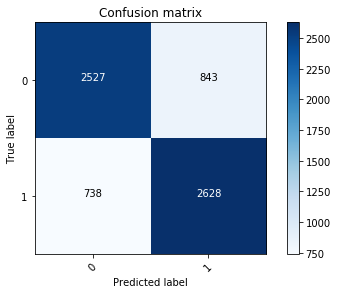




Normalized confusion matrix


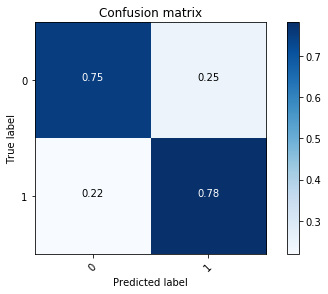

In [426]:
# Multinomial Bayes Classifier with Hyperparameters tuned as per the gridsearch results:
text_mnb = Pipeline([('vect', CountVectorizer(binary=False, max_df=0.2, ngram_range=(1,1))),
                     ('tfidf', TfidfTransformer(norm='l2')),
                     ('clf', MultinomialNB(alpha=0.5, fit_prior=False)),])
text_mnb.fit(X_train, y_train)
predicted_test = text_mnb.predict(X_test)
predicted_train = text_mnb.predict(X_train)
print("Multinomial Naive Bayes Results")
print("")
evaluate(y_train, predicted_train, y_test, predicted_test, class_names=class_names)

Based on our GridSearch, we have tuned our hyperparameters for our Multinomial Naive Bayes Classifier and have come up with an even better Accuracy, Precision and F1 Score, while the Recall score dropped slightly, overall though it's a good outcome:

* Prior Testing Accuracy:  0.7578681710213777

* New Testing Accuracy:  0.765290973871734
 

* Prior Testing Recall:  0.8042186571598336

* New Testing Recall:  0.7807486631016043


* Prior Testing Precision:  0.7357977711334602

* New Testing Precision:  0.7571305099394987


* Prior Testing F1 Score:  0.7464632013988237

* New Testing F1 Score:  0.7687582272926723


<a id='Part_5'></a>

# Final Model

In [429]:
# Dump the trained decision tree classifier with Pickle
mnb_pkl_filename = 'mnb_classifier1.pkl'
# Open the file to save as pkl file
mnb_model_pkl = open(mnb_pkl_filename, 'wb')
pickle.dump(text_mnb, mnb_model_pkl)
# Close the pickle instances
mnb_model_pkl.close()



<a id='Part_6'></a>

# Conclusions

We have a decently functioning model that can predict depression/suicidal ideation in social media posts with ~77% accuracy. Considering the imperfect dataset we are working with, it is a pretty good model!

Our relatively high recall value of 78% ensures that we miss as few suicidal posters as possible when implementing our model!

### Up Next... Can we classify suicidal ideation from depressed/anxious forum posters based on the language of their social media posts?